# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
count_steps = 0
done = False
while not done:                                    # exit loop if episode finished
    count_steps += 1
    print("\rStep: ", count_steps, end="")
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    
print("\nScore: {}".format(score))

Step:  300
Score: 0.0


When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import torch.nn as nn
import time
from dqn_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0)


def dqn(n_episodes=4000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    starting_time = time.time()        # for timing reasons we notice the starting time
    last_time = starting_time          # time to see how long the last hundred episodes took
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    max_score = 0.                     # initialize the maximal score to zero

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        done = False
        while not done:                                    # do untill done
            action = agent.act(state, eps)                 # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f} \t Time passed: {:.1f} mins'.format(i_episode, np.mean(scores_window), (time.time() - starting_time)/60.), end="")
        if i_episode % 100 == 0:            
            print('\rEpisode {}\tAverage Score: {:.2f} \tlast 100 Episodes took {:.1f} mins'.format(i_episode, np.mean(scores_window), (time.time() - last_time)/60.))
            last_time = time.time()
        if np.mean(scores_window)>=max(13., max_score):
            print('\nNew Maximum Average Score at {:d} episodes!\tAverage Score: {:.2f} \t Time passed: {:.1f} mins'.format(i_episode, np.mean(scores_window), (time.time() - starting_time)/60.))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            max_score = np.mean(scores_window)
    return scores

Working on device: cpu


In [9]:
try:
    env = UnityEnvironment(file_name="./Banana_Linux_NoVis/Banana.x86_64")

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    scores = dqn()
finally:
    env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.88 	last 100 Episodes took 1.5 mins
Episode 200	Average Score: 4.10 	last 100 Episodes took 1.5 mins
Episode 300	Average Score: 7.58 	last 100 Episodes took 1.5 mins
Episode 400	Average Score: 10.00 	last 100 Episodes took 1.6 mins
Episode 500	Average Score: 12.54 	last 100 Episodes took 1.5 mins
Episode 530	Average Score: 13.03 	 Time passed: 8.2 mins
New Maximum Average Score at 530 episodes!	Average Score: 13.03 	 Time passed: 8.2 mins
Episode 544	Average Score: 13.05 	 Time passed: 8.4 mins
New Maximum Average Score at 544 episodes!	Average Score: 13.05 	 Time passed: 8.4 mins
Episode 545	Average Score: 13.10 	 Time passed: 8.5 mins
New Maximum Average Score at 545 episodes!	Average Score: 13.10 	 Time passed: 8.5 mins
Episode 546	Average Score: 13.21 	 Time passed: 8.5 mins
New Maximum Average Score at 546 episodes!	Average Score: 13.21 	 Time passed: 8.5 mins
Episode 547	Average Score: 13.25 	 Time passed: 8.5 mins
New Maximum Average Score at 547 epi

Episode 699	Average Score: 15.15 	 Time passed: 10.9 mins
New Maximum Average Score at 699 episodes!	Average Score: 15.15 	 Time passed: 10.9 mins
Episode 700	Average Score: 15.10 	last 100 Episodes took 1.6 mins
Episode 711	Average Score: 15.15 	 Time passed: 11.1 mins
New Maximum Average Score at 711 episodes!	Average Score: 15.15 	 Time passed: 11.1 mins
Episode 727	Average Score: 15.16 	 Time passed: 11.3 mins
New Maximum Average Score at 727 episodes!	Average Score: 15.16 	 Time passed: 11.3 mins
Episode 749	Average Score: 15.20 	 Time passed: 11.7 mins
New Maximum Average Score at 749 episodes!	Average Score: 15.20 	 Time passed: 11.7 mins
Episode 750	Average Score: 15.24 	 Time passed: 11.7 mins
New Maximum Average Score at 750 episodes!	Average Score: 15.24 	 Time passed: 11.7 mins
Episode 751	Average Score: 15.35 	 Time passed: 11.7 mins
New Maximum Average Score at 751 episodes!	Average Score: 15.35 	 Time passed: 11.7 mins
Episode 752	Average Score: 15.36 	 Time passed: 11.7

Episode 3000	Average Score: 15.14 	last 100 Episodes took 1.6 mins
Episode 3100	Average Score: 14.74 	last 100 Episodes took 1.6 mins
Episode 3200	Average Score: 14.90 	last 100 Episodes took 1.6 mins
Episode 3300	Average Score: 14.65 	last 100 Episodes took 1.7 mins
Episode 3400	Average Score: 16.04 	last 100 Episodes took 1.7 mins
Episode 3500	Average Score: 16.45 	last 100 Episodes took 1.6 mins
Episode 3509	Average Score: 16.99 	 Time passed: 56.9 mins
New Maximum Average Score at 3509 episodes!	Average Score: 16.99 	 Time passed: 56.9 mins
Episode 3511	Average Score: 16.99 	 Time passed: 56.9 mins
New Maximum Average Score at 3511 episodes!	Average Score: 16.99 	 Time passed: 56.9 mins
Episode 3526	Average Score: 17.06 	 Time passed: 57.2 mins
New Maximum Average Score at 3526 episodes!	Average Score: 17.06 	 Time passed: 57.2 mins
Episode 3527	Average Score: 17.07 	 Time passed: 57.2 mins
New Maximum Average Score at 3527 episodes!	Average Score: 17.07 	 Time passed: 57.2 mins
Ep

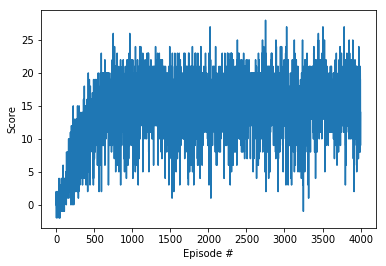

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
# plt.show()
# save the plot to a png file
plt.savefig('learning_curve.png')

### 4. The Performance of a Trained Agent

Now we look at the trained agent

In [11]:
try:
    env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # initialize the agent
    agent = Agent(state_size=state_size, action_size=action_size, seed=0)
    # transferlerning from saved state and set to evaluate
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    agent.qnetwork_local.eval()

    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                         # initialize the score
    done = False
    while not done:
        action =  agent.act(state, 0.01)                 # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step

    
    print("Score: {}".format(score))

finally:
    env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Working on device: cpu
Score: 17.0
